In [ ]:
!pip install imblearn

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as scs
import joblib
import yaml
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

## 1. Todo List

1. Missing value handling
- pm10      : mean kelas
- pm25      : mean kelas
- so2       : mean
- co        : median
- o3        : median
- no2       : median

3. Balancing label baik dan tidak baik

4. Outlier removal

## 2. Import Params

In [ ]:
params_dir = "/content/params.yaml"

In [ ]:
def load_params(param_dir):
    with open(param_dir, "r") as file:
        params = yaml.safe_load(file)

    return params

In [ ]:
def params_updater(key, value, params, params_dir):
    params = params.copy()
    params[key] = value

    with open(params_dir, "w") as file:
        yaml.dump(params, file)

    params = load_params(params_dir)

    return params

In [ ]:
params = load_params(params_dir)

## 3. Load Dataset

In [ ]:
x_train = joblib.load("/content/x_train.pkl")
y_train = joblib.load("/content/y_train.pkl")

x_valid = joblib.load("/content/x_valid.pkl")
y_valid = joblib.load("/content/y_valid.pkl")

x_test = joblib.load("/content/x_test.pkl")
y_test = joblib.load("/content/y_test.pkl")

In [ ]:
df = pd.concat([x_train, y_train], axis = 1)

valid_set = pd.concat([x_valid, y_valid], axis = 1)

test_set = pd.concat([x_test, y_test], axis = 1)

## 4. Handling Missing Value

In [ ]:
def nan_detector(set_data):
    set_data = set_data.copy()
    set_data.replace(-1, np.nan, inplace = True)
    return set_data

### 4.1. Convert -1 to NaN

#### 4.1.1. Trainset

In [ ]:
df.describe()

,pm10,pm25,so2,co,o3,no2
count,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000
mean,50.757504,74.639021,32.990521,11.683254,30.887836,19.442338
std,17.005615,27.531714,15.149685,4.961829,15.441335,9.668346
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,42.000000,60.000000,24.000000,9.000000,21.000000,13.000000
50%,54.000000,77.000000,33.000000,11.000000,28.000000,18.000000
75%,61.000000,91.000000,43.000000,14.000000,38.000000,25.000000
max,179.000000,174.000000,82.000000,43.000000,151.000000,65.000000


In [ ]:
df.isnull().sum()

stasiun     0
pm10        0
pm25        0
so2         0
co          0
o3          0
no2         0
categori    0
dtype: int64

In [ ]:
df = nan_detector(df)

In [ ]:
df.isnull().sum()

stasiun      0
pm10        35
pm25        55
so2         75
co          11
o3          35
no2         14
categori     0
dtype: int64

#### 4.1.2. Validset

In [ ]:
valid_set.describe()

,pm10,pm25,so2,co,o3,no2
count,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000
mean,50.538745,73.199262,32.952030,12.450185,33.055351,19.365314
std,16.870898,27.885031,15.219916,5.889437,17.631639,9.457671
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,41.500000,59.000000,23.500000,9.000000,23.000000,13.000000
50%,54.000000,76.000000,32.000000,11.000000,29.000000,18.000000
75%,62.000000,92.500000,44.000000,15.000000,42.000000,25.000000
max,92.000000,145.000000,80.000000,47.000000,134.000000,57.000000


In [ ]:
valid_set.isnull().sum()

stasiun     0
pm10        0
pm25        0
so2         0
co          0
o3          0
no2         0
categori    0
dtype: int64

In [ ]:
valid_set = nan_detector(valid_set)

In [ ]:
valid_set.isnull().sum()

stasiun      0
pm10         9
pm25        14
so2         15
co           3
o3           9
no2          2
categori     0
dtype: int64

#### 4.1.1. Testset

In [ ]:
test_set = nan_detector(test_set)

In [ ]:
test_set.isnull().sum()

stasiun      0
pm10         8
pm25        15
so2          8
co           6
o3           8
no2          3
categori     0
dtype: int64

### 4.2. Handling in PM10

#### 4.2.1. Trainset

In [ ]:
df['categori'].value_counts()

BAIK           1076
TIDAK SEHAT     190
Name: categori, dtype: int64

In [ ]:
impute_1 = int(df[df.categori == "BAIK"].pm10.mean())
impute_0 = int(df[df.categori == "TIDAK SEHAT"].pm10.mean())


In [ ]:
impute_1, impute_0

(48, 70)

In [ ]:
params = params_updater("missing_value_pm10", {"BAIK": 48, "TIDAK SEHAT": 70}, params, params_dir)

In [ ]:
df[df.categori == "BAIK"].pm10.isnull().sum(), df[df.categori == "TIDAK SEHAT"].pm10.isnull().sum()

(29, 6)

In [ ]:
df.loc[df[(df.categori == "BAIK") & (df.pm10.isnull() == True)].index, "pm10"] = impute_1
df.loc[df[(df.categori == "TIDAK SEHAT") & (df.pm10.isnull() == True)].index, "pm10"] = impute_0

In [ ]:
df[df.categori == "BAIK"].pm10.isnull().sum(), df[df.categori == "TIDAK SEHAT"].pm10.isnull().sum()

(0, 0)

#### 4.2.2. Validset

In [ ]:
valid_set[valid_set.categori == "BAIK"].pm10.isnull().sum(), valid_set[valid_set.categori == "TIDAK SEHAT"].pm10.isnull().sum()

(7, 2)

In [ ]:
valid_set.loc[valid_set[(valid_set.categori == "BAIK") & (valid_set.pm10.isnull() == True)].index, "pm10"] = impute_1
valid_set.loc[valid_set[(valid_set.categori == "TIDAK SEHAT") & (valid_set.pm10.isnull() == True)].index, "pm10"] = impute_0

In [ ]:
valid_set[valid_set.categori == "BAIK"].pm10.isnull().sum(), valid_set[valid_set.categori == "TIDAK SEHAT"].pm10.isnull().sum()

(0, 0)

#### 4.2.3. Testset

In [ ]:
test_set[test_set.categori == "BAIK"].pm10.isnull().sum(), test_set[test_set.categori == "TIDAK SEHAT"].pm10.isnull().sum()

(5, 3)

In [ ]:
test_set.loc[test_set[(test_set.categori == "BAIK") & (test_set.pm10.isnull() == True)].index, "pm10"] = impute_1
test_set.loc[test_set[(test_set.categori == "TIDAK SEHAT") & (test_set.pm10.isnull() == True)].index, "pm10"] = impute_0

In [ ]:
test_set[test_set.categori == "BAIK"].pm10.isnull().sum(), test_set[test_set.categori == "TIDAK SEHAT"].pm10.isnull().sum()

(0, 0)

### 4.3. Handling in PM25

#### 4.3.1. Trainset

In [ ]:
impute_1 = int(df[df.categori == "BAIK"].pm25.mean())
impute_0 = int(df[df.categori == "TIDAK SEHAT"].pm25.mean())

In [ ]:
impute_1, impute_0

(71, 113)

In [ ]:
params = params_updater("missing_value_pm25", {"BAIK": 71, "TIDAK SEHAT": 113}, params, params_dir)

In [ ]:
df[df.categori == "BAIK"].pm25.isnull().sum(), df[df.categori == "TIDAK SEHAT"].pm25.isnull().sum()

(55, 0)

In [ ]:
df.loc[df[(df.categori == "BAIK") & (df.pm25.isnull() == True)].index, "pm25"] = impute_1
df.loc[df[(df.categori == "TIDAK SEHAT") & (df.pm25.isnull() == True)].index, "pm25"] = impute_0

In [ ]:
df[df.categori == "BAIK"].pm10.isnull().sum(), df[df.categori == "TIDAK SEHAT"].pm10.isnull().sum()

(0, 0)

#### 4.3.2. Validset

In [ ]:
valid_set[valid_set.categori == "BAIK"].pm25.isnull().sum(), valid_set[valid_set.categori == "TIDAK SEHAT"].pm25.isnull().sum()

(14, 0)

In [ ]:
valid_set.loc[valid_set[(valid_set.categori == "BAIK") & (valid_set.pm25.isnull() == True)].index, "pm25"] = impute_1
valid_set.loc[valid_set[(valid_set.categori == "TIDAK SEHAT") & (valid_set.pm25.isnull() == True)].index, "pm25"] = impute_0

In [ ]:
df[df.categori == "BAIK"].pm10.isnull().sum(), df[df.categori == "TIDAK SEHAT"].pm10.isnull().sum()

(0, 0)

#### 4.3.3. Testset

In [ ]:
test_set[test_set.categori == "BAIK"].pm25.isnull().sum(), test_set[test_set.categori == "TIDAK SEHAT"].pm25.isnull().sum()

(15, 0)

In [ ]:
test_set.loc[test_set[(test_set.categori == "BAIK") & (test_set.pm25.isnull() == True)].index, "pm25"] = impute_1
test_set.loc[test_set[(test_set.categori == "TIDAK SEHAT") & (test_set.pm25.isnull() == True)].index, "pm25"] = impute_0

In [ ]:
test_set[test_set.categori == "BAIK"].pm10.isnull().sum(), test_set[test_set.categori == "TIDAK SEHAT"].pm10.isnull().sum()

(0, 0)

### 4.4. Handling in SO2, CO, O3, dan NO2

In [ ]:
impute_so2 = int(df.so2.mean())
impute_co = int(df.co.median())
impute_o3 = int(df.o3.median())
impute_no2 = int(df.no2.median())


In [ ]:
impute_values = {"so2" : impute_so2, "co" : impute_co, "o3" : impute_o3, "no2" : impute_no2}

In [ ]:
impute_values

{'so2': 35, 'co': 11, 'o3': 28, 'no2': 18}

In [ ]:
params = params_updater("missing_value_so2", 35, params, params_dir)
params = params_updater("missing_value_co", 11, params, params_dir)
params = params_updater("missing_value_o3", 28, params, params_dir)
params = params_updater("missing_value_no2", 18, params, params_dir)

In [ ]:
df.isnull().sum()

stasiun      0
pm10         0
pm25         0
so2         75
co          11
o3          35
no2         14
categori     0
dtype: int64

In [ ]:
df.fillna(value = impute_values, inplace = True)

In [ ]:
df.isnull().sum()

stasiun     0
pm10        0
pm25        0
so2         0
co          0
o3          0
no2         0
categori    0
dtype: int64

#### 4.4.2. Validset

In [ ]:
valid_set.isnull().sum()

stasiun      0
pm10         0
pm25         0
so2         15
co           3
o3           9
no2          2
categori     0
dtype: int64

In [ ]:
valid_set.fillna(value = impute_values, inplace = True)

In [ ]:
valid_set.isnull().sum()

stasiun     0
pm10        0
pm25        0
so2         0
co          0
o3          0
no2         0
categori    0
dtype: int64

#### 4.4.3. Testset

In [ ]:
test_set.fillna(value = impute_values, inplace = True)

In [ ]:
test_set.isnull().sum()

stasiun     0
pm10        0
pm25        0
so2         0
co          0
o3          0
no2         0
categori    0
dtype: int64

## 5. Encoding Stasiun

In [ ]:
ohe_statiun = OneHotEncoder(sparse = False)

In [ ]:
ohe_statiun.fit(np.array(params["range_stasiun"]).reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(sparse=False, sparse_output=False)

In [ ]:
ohe_statiun.categories_

[array(['DKI1 (Bunderan HI)', 'DKI2 (Kelapa Gading)', 'DKI3 (Jagakarsa)',
        'DKI4 (Lubang Buaya)', 'DKI5 (Kebon Jeruk) Jakarta Barat'],
       dtype='<U32')]

In [ ]:
joblib.dump(ohe_statiun, "ohe_stasiun.pkl")

['ohe_stasiun.pkl']

### 5.1. Trainset

In [ ]:
stasiun_features = ohe_statiun.transform(np.array(df.stasiun.to_list()).reshape(-1, 1))

In [ ]:
stasiun_features = pd.DataFrame(stasiun_features, columns = params["range_stasiun"])

In [ ]:
stasiun_features.set_index(df.index, inplace = True)

In [ ]:
df = pd.concat([stasiun_features, df], axis = 1)

In [ ]:
df.drop(columns = "stasiun", inplace = True)

### 5.2. Validset

In [ ]:
stasiun_features = ohe_statiun.transform(np.array(valid_set.stasiun.to_list()).reshape(-1, 1))

In [ ]:
stasiun_features = pd.DataFrame(stasiun_features, columns = params["range_stasiun"])

In [ ]:
stasiun_features.set_index(valid_set.index, inplace = True)

In [ ]:
valid_set = pd.concat([stasiun_features, valid_set], axis = 1)

In [ ]:
valid_set.drop(columns = "stasiun", inplace = True)

### 5.3. Testset

In [ ]:
stasiun_features = ohe_statiun.transform(np.array(test_set.stasiun.to_list()).reshape(-1, 1))

In [ ]:
stasiun_features = pd.DataFrame(stasiun_features, columns = params["range_stasiun"])

In [ ]:
stasiun_features.set_index(test_set.index, inplace = True)

In [ ]:
test_set = pd.concat([stasiun_features, test_set], axis = 1)

In [ ]:
test_set.drop(columns = "stasiun", inplace = True)

## 6. Balancing Label

<Axes: xlabel='categori', ylabel='Count'>

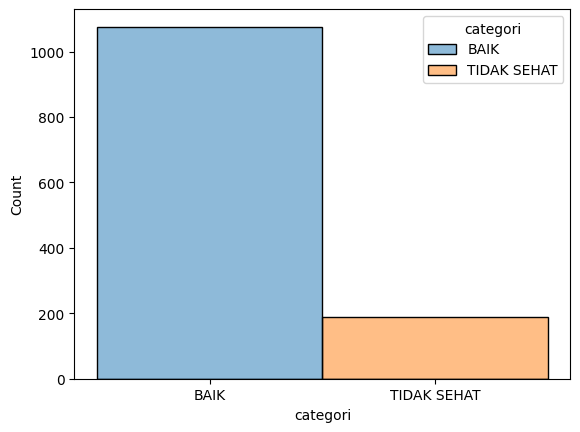

In [ ]:
sns.histplot(data = df, x = "categori", hue = "categori")

### 6.1. Undersampling

In [ ]:
rus = RandomUnderSampler(random_state = 26)

In [ ]:
x_rus, y_rus = rus.fit_resample(df.drop("categori", axis = 1), df.categori)

In [ ]:
df_rus = pd.concat([x_rus, y_rus], axis = 1)

<Axes: xlabel='categori', ylabel='Count'>

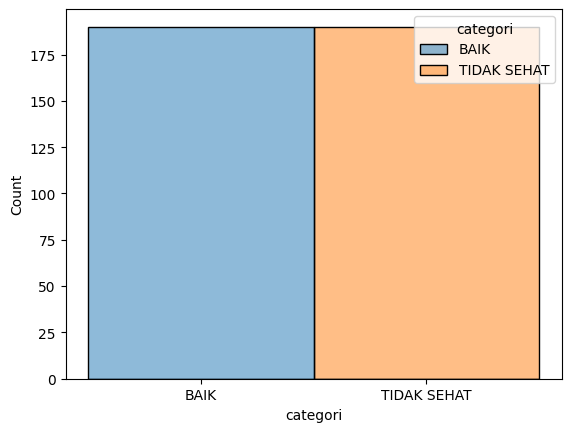

In [ ]:
sns.histplot(df_rus, x = "categori", hue = "categori")

### 6.2. Oversampling

In [ ]:
ros = RandomOverSampler(random_state = 11)

In [ ]:
x_ros, y_ros = ros.fit_resample(df.drop("categori", axis = 1), df.categori)

In [ ]:
df_ros = pd.concat([x_ros, y_ros], axis = 1)

<Axes: xlabel='categori', ylabel='Count'>

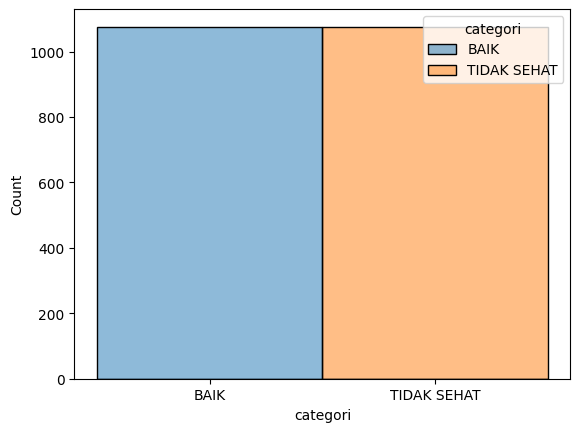

In [ ]:
sns.histplot(df_ros, x = "categori", hue = "categori")

### 6.3. SMOTE

In [ ]:
sm = SMOTE(random_state = 112)

In [ ]:
x_sm, y_sm = sm.fit_resample(df.drop("categori", axis = 1), df.categori)

In [ ]:
df_sm = pd.concat([x_sm, y_sm], axis = 1)

<Axes: xlabel='categori', ylabel='Count'>

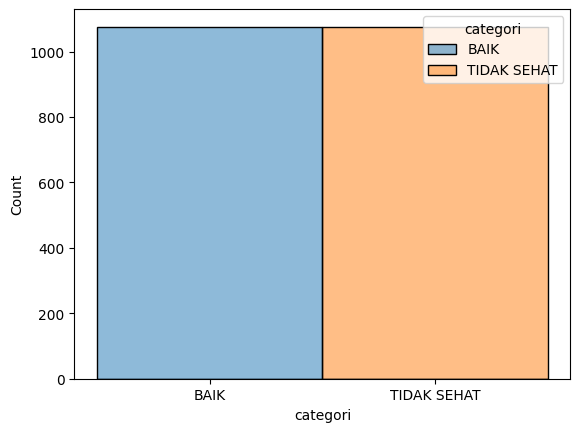

In [ ]:
sns.histplot(df_ros, x = "categori", hue = "categori")

## 7. Label Encoding

In [ ]:
le_categori = LabelEncoder()

In [ ]:
le_categori.fit(params["label_categories_new"])

LabelEncoder()

In [ ]:
joblib.dump(le_categori, "le_categori.pkl")

['le_categori.pkl']

In [ ]:
params["label_categories_new"]

['BAIK', 'TIDAK SEHAT']

### 7.1. Undersampling set

In [ ]:
list(y_rus.unique()) == params["label_categories_new"]

True

In [ ]:
y_rus = le_categori.transform(y_rus)

### 7.2. Oversampling set

In [ ]:
list(y_ros.unique()) == params["label_categories_new"]

True

In [ ]:
y_ros = le_categori.transform(y_ros)

#### 7.3. SMOTE

In [ ]:
list(y_sm.unique()) == params["label_categories_new"]

True

In [ ]:
y_sm = le_categori.transform(y_sm)

#### 7.4. Validation Set

In [ ]:
len(set(valid_set.categori.unique()) - set(params["label_categories_new"])) == 0

True

In [ ]:
valid_set.categori = le_categori.transform(valid_set.categori)

#### 7.5. Test Set

In [ ]:
len(set(test_set.categori.unique()) - set(params["label_categories_new"])) == 0

True

In [ ]:
test_set.categori = le_categori.transform(test_set.categori)

## 8. Dump Data Training

In [ ]:
joblib.dump(x_rus, "/content/processed/x_rus.pkl")
joblib.dump(y_rus, "/content/processed/y_rus.pkl")

joblib.dump(x_ros, "/content/processed/x_ros.pkl")
joblib.dump(y_ros, "/content/processed/y_ros.pkl")

joblib.dump(x_sm, "/content/processed/x_sm.pkl")
joblib.dump(y_sm, "/content/processed/y_sm.pkl")

joblib.dump(valid_set.drop(columns = "categori"), "/content/processed/x_valid_feng.pkl")
joblib.dump(valid_set.categori, "/content/processed/y_valid_feng.pkl")

joblib.dump(test_set.drop(columns = "categori"), "/content/processed/x_test_feng.pkl")
joblib.dump(test_set.categori, "/content/processed/y_test_feng.pkl")

['/content/processed/x_rus.pkl']